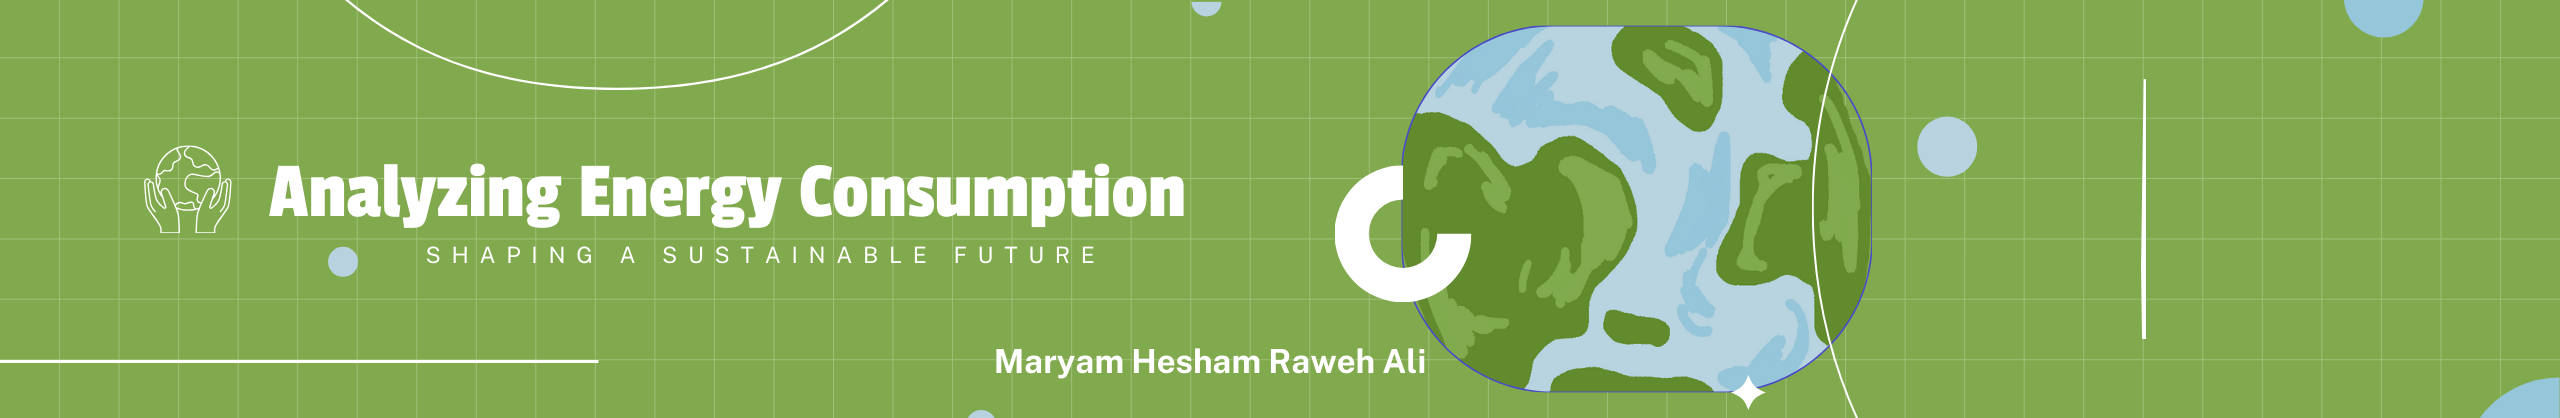

#Set up Infrastructure

In [2]:
%pip install pyspark==3.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=8b931f244252d567ba8e0deb74e3b143b4c507f8de74a9245850c886156ab853
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
import pyspark
print(pyspark.__version__)

3.5.0


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
       .master("local[*]") \
       .appName("energy consumption") \
       .config("spark.driver.memory", "9g")\
       .getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

spark.sparkContext._conf.getAll()  #to check the config

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[('spark.app.name', 'energy consumption'),
 ('spark.app.submitTime', '1699812568235'),
 ('spark.app.startTime', '1699812568631'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', '502605eca321'),
 ('spark.app.id', 'local-1699812571643'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=ja

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive

/content/drive


In [7]:
%pwd

'/content/drive'

#Data Collection

In [ ]:
# !pip install kaggle

In [ ]:
# import kaggle
# import pandas as pd
# import os
# import zipfile
# import warnings
# import numpy as np

In [ ]:
# !kaggle datasets download -d jeanmidev/smart-meters-in-london

In [ ]:
# with zipfile.ZipFile('smart-meters-in-london.zip', 'r') as zipref:
#     zipref.extractall()

In [ ]:
# %ls

In [ ]:
# current_directory = os.getcwd()

# # Iterate over all directories and files in the current directory
# for root, dirs, files in os.walk(current_directory):
#     for file in files:
#         print(file)

In [ ]:
# # acorn_details = pd.read_csv('acorn_details.csv'a, encoding='latin-1')
# # acorn_details

# for root, dirs, files in os.walk(current_directory):
#     for file in files:
#         if file.endswith(".csv"):
#             print("\033[1m" + file + "\033[0m")

#             file_path = os.path.join(root, file)
#             df = pd.read_csv(file_path, encoding='latin-1')

#             print(df.columns)
#             print()

In [ ]:
# def concat_files_in_dir(source_directory, destination_directory, output_filename):
#     dfs = []

#     # Iterate over all files in the source directory
#     for filename in os.listdir(source_directory):
#         if filename.endswith('.csv'):
#             file_path = os.path.join(source_directory, filename)

#             # Read the CSV file into a DataFrame
#             df = pd.read_csv(file_path)
#             dfs.append(df)

#     if len(dfs) > 0:
#         concatenated_df = pd.concat(dfs, axis=0)
#         concatenated_df = concatenated_df.reset_index(drop=True)

#         output_path = os.path.join(destination_directory, output_filename)
#         concatenated_df.to_csv(output_path, index=False)
#         print("Concatenation completed. Saved to:", output_path)
#     else:
#         print("No CSV files found in the specified directory.")

In [ ]:
# destination_directory = r'C:\Users\Abuda\Desktop\BIG DATA PROJECT\DATA'

In [ ]:
# source_directory = r'C:\Users\Abuda\Desktop\BIG DATA PROJECT\halfhourly_dataset\halfhourly_dataset'

# output_filename = 'concatenated_data_halfhourly.csv'

# concat_files_in_dir(source_directory, destination_directory, output_filename)

In [ ]:
# source_directory = r'C:\Users\Abuda\Desktop\BIG DATA PROJECT\hhblock_dataset\hhblock_dataset'

# output_filename = 'concatenated_data_hhblock.csv'

# concat_files_in_dir(source_directory, destination_directory, output_filename)


#ETL


##Import libraries and packages needed

In [8]:
from pyspark.sql.types import StringType, TimestampType, DoubleType, DateType, FloatType, IntegerType, StructType, StructField
from pyspark.sql.functions import col, lit, when, sum, window, approx_count_distinct, last, mean, median, stddev, year, round, month, dayofmonth, dayofweek, hour, date_format, min, max, expr
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
import plotly.express as px
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from functools import reduce
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, LinearRegression

##Changing data type and reading my data

In [9]:
# Define the schema
schema = StructType([
    StructField("LCLid", StringType(), nullable=True),
    StructField("tstp", TimestampType(), nullable=True),
    StructField("energy(kWh/hh)", DoubleType(), nullable=True)
])

# Read CSV file with the defined schema
halfhourly = spark.read.csv('/content/drive/MyDrive/concatenated_data_halfhourly.csv', header=True, schema=schema)
# halfhourly = halfhourly.limit(500000)
halfhourly.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- tstp: timestamp (nullable = true)
 |-- energy(kWh/hh): double (nullable = true)



In [10]:
schema = StructType([
    StructField("Bank holidays", DateType(), nullable=True),
    StructField("Type", StringType(), nullable=True)
])

# Read uk_bank_holidays
holidays = spark.read.csv('/content/drive/MyDrive/uk_bank_holidays.csv', header=True, schema=schema)
holidays.printSchema()

root
 |-- Bank holidays: date (nullable = true)
 |-- Type: string (nullable = true)



In [11]:
schema = StructType([
    StructField("LCLid", StringType(), nullable=True),
    StructField("stdorToU", StringType(), nullable=True),
    StructField("Acorn", StringType(), nullable=True),
    StructField("Acorn_grouped", StringType(), nullable=True),
    StructField("file", StringType(), nullable=True)
])

# Read informations_households
info_households = spark.read.csv('/content/drive/MyDrive/informations_households.csv', header=True, schema=schema)
info_households.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- file: string (nullable = true)



In [12]:
schema = StructType([
    StructField("visibility", FloatType(), nullable=True),
    StructField("windBearing", IntegerType(), nullable=True),
    StructField("temperature", FloatType(), nullable=True),
    StructField("time", TimestampType(), nullable=True),
    StructField("dewPoint", FloatType(), nullable=True),
    StructField("pressure", FloatType(), nullable=True),
    StructField("apparentTemperature", FloatType(), nullable=True),
    StructField("windSpeed", FloatType(), nullable=True),
    StructField("precipType", StringType(), nullable=True),
    StructField("icon", StringType(), nullable=True),
    StructField("humidity", FloatType(), nullable=True),
    StructField("summary", StringType(), nullable=True)
])

# Read weather_hourly_darksky
weather = spark.read.csv('/content/drive/MyDrive/weather_hourly_darksky.csv', header=True, schema=schema)
weather.printSchema()

root
 |-- visibility: float (nullable = true)
 |-- windBearing: integer (nullable = true)
 |-- temperature: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- dewPoint: float (nullable = true)
 |-- pressure: float (nullable = true)
 |-- apparentTemperature: float (nullable = true)
 |-- windSpeed: float (nullable = true)
 |-- precipType: string (nullable = true)
 |-- icon: string (nullable = true)
 |-- humidity: float (nullable = true)
 |-- summary: string (nullable = true)



##Viewing my data

In [ ]:
halfhourly.show(3)

+---------+-------------------+--------------+
|    LCLid|               tstp|energy(kWh/hh)|
+---------+-------------------+--------------+
|MAC000002|2012-10-12 00:30:00|           0.0|
|MAC000002|2012-10-12 01:00:00|           0.0|
|MAC000002|2012-10-12 01:30:00|           0.0|
+---------+-------------------+--------------+
only showing top 3 rows



In [ ]:
holidays.show(3)

+-------------+-------------------+
|Bank holidays|               Type|
+-------------+-------------------+
|   2012-12-26|         Boxing Day|
|   2012-12-25|      Christmas Day|
|   2012-08-27|Summer bank holiday|
+-------------+-------------------+
only showing top 3 rows



In [ ]:
info_households.show(3)

+---------+--------+-------+-------------+-------+
|    LCLid|stdorToU|  Acorn|Acorn_grouped|   file|
+---------+--------+-------+-------------+-------+
|MAC005492|     ToU| ACORN-|       ACORN-|block_0|
|MAC001074|     ToU| ACORN-|       ACORN-|block_0|
|MAC000002|     Std|ACORN-A|     Affluent|block_0|
+---------+--------+-------+-------------+-------+
only showing top 3 rows



In [ ]:
weather.show(3)

+----------+-----------+-----------+-------------------+--------+--------+-------------------+---------+----------+-------------------+--------+-------------+
|visibility|windBearing|temperature|               time|dewPoint|pressure|apparentTemperature|windSpeed|precipType|               icon|humidity|      summary|
+----------+-----------+-----------+-------------------+--------+--------+-------------------+---------+----------+-------------------+--------+-------------+
|      5.97|        104|      10.24|2011-11-11 00:00:00|    8.86| 1016.76|              10.24|     2.77|      rain|partly-cloudy-night|    0.91|Partly Cloudy|
|      4.88|         99|       9.76|2011-11-11 01:00:00|    8.83| 1016.63|               8.24|     2.95|      rain|partly-cloudy-night|    0.94|Partly Cloudy|
|       3.7|         98|       9.46|2011-11-11 02:00:00|    8.79| 1016.36|               7.76|     3.17|      rain|partly-cloudy-night|    0.96|Partly Cloudy|
+----------+-----------+-----------+----------

#Data Preprocessing

In [14]:
info_households = info_households.drop('file')

In [ ]:
weather.selectExpr("min(time)", "max(time)").show()

+-------------------+-------------------+
|          min(time)|          max(time)|
+-------------------+-------------------+
|2011-11-01 00:00:00|2014-03-31 22:00:00|
+-------------------+-------------------+



joining info households dataset

Cleaning from duplicates and nulls

In [15]:
# halfhourly = halfhourly.fillna(0, subset=["energy(kWh/hh)"])

# Forward-fill missing values in the "energy(kWh/hh)" column
# halfhourly = halfhourly.withColumn(
#     "energy(kWh/hh)",
#     last("energy(kWh/hh)", ignorenulls=True).over(
#         Window.orderBy("tstp").rowsBetween(Window.unboundedPreceding, 0)
#     )
# )

halfhourly = halfhourly.drop_duplicates()
halfhourly = halfhourly.na.drop()

In [16]:
# from pyspark.sql.functions import sum as spark_sum, window, col

halfhourly = halfhourly \
    .groupBy('LCLid', window('tstp', '1 hour')) \
    .agg(sum('energy(kWh/hh)').alias('sum_energy')) \
    .select('LCLid', col('window.start').alias('tstp'), 'sum_energy')

In [17]:
halfhourly = halfhourly.join(info_households, on='LCLid')

In [18]:
halfhourly = halfhourly.orderBy('tstp')

In [19]:
halfhourly = halfhourly.withColumn('sum_energy', round(halfhourly['sum_energy'], 3))

In [20]:
halfhourly.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- tstp: timestamp (nullable = true)
 |-- sum_energy: double (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)



In [ ]:
halfhourly.count()

83925602

Statified Sampling in respect of 'Acorn Grouped'

In [21]:
fractions = halfhourly.select('Acorn_grouped').distinct().withColumn('fraction', lit(0.1)).rdd.collectAsMap()
#collect the data as a Python dictionary where each unique key in the RDD corresponds to a value. The keys and values are then stored in the dictionary.

In [ ]:
fractions

{'Adversity': 0.1,
 'ACORN-': 0.1,
 'Affluent': 0.1,
 'ACORN-U': 0.1,
 'Comfortable': 0.1}

In [22]:
#stratified sampling
halfhourly = halfhourly.stat.sampleBy('Acorn_grouped', fractions, seed=42)

In [ ]:
halfhourly.count()

8392330

67,138,924 not considered

checking NULLS

In [ ]:
(halfhourly.select([
    sum(col(column).isNull().cast("integer")).alias(column)
    for column in halfhourly.columns
])).show()

+-----+----+--------------+--------+-----+-------------+
|LCLid|tstp|energy(kWh/hh)|stdorToU|Acorn|Acorn_grouped|
+-----+----+--------------+--------+-----+-------------+
|    0|   0|             0|       0|    0|            0|
+-----+----+--------------+--------+-----+-------------+



In [ ]:
def unique(col_name):
  for row in halfhourly.select(col_name).distinct().collect():
    print(row[col_name])

In [ ]:
unique('Acorn_grouped')

Adversity
ACORN-
Affluent
ACORN-U
Comfortable


In [23]:
halfhourly = halfhourly.withColumnRenamed("tstp", "time")

In [ ]:
(halfhourly.agg(*(approx_count_distinct(c).alias(c) for c in halfhourly.columns))).show()

+-----+-----+----------+--------+-----+-------------+
|LCLid| time|sum_energy|stdorToU|Acorn|Acorn_grouped|
+-----+-----+----------+--------+-----+-------------+
| 5229|17807|     10676|       2|   18|            5|
+-----+-----+----------+--------+-----+-------------+



#Exploratory Data Analysis and Statistical Analysis

In [ ]:
halfhourly.describe(['sum_energy']).show()

+-------+-------------------+
|summary|         sum_energy|
+-------+-------------------+
|  count|           25178998|
|   mean|0.42357588947741676|
| stddev| 0.5610002753402356|
|    min|                0.0|
|    max|             18.461|
+-------+-------------------+



* The mean value of 0.424 kWh represents the central tendency of the energy consumption data. It indicates that, on average, the expected energy consumption over the given years (2011-2014) is approximately 0.424 kWh. This value provides an estimate of the typical energy usage during that period.

* The standard deviation value of around 0.561 kWh indicates the spread of the energy consumption values around the mean. It measures the average amount by which each observation deviates from the mean. A higher standard deviation suggests that the energy consumption values are more widely distributed or dispersed, indicating a greater degree of variation in the dataset.

In [24]:
halfhourly = halfhourly.withColumn('year', year('time')) \
                    .withColumn('month', month('time')) \
                    .withColumn('day', dayofmonth('time')) \
                    .withColumn('dayOfWeek', dayofweek('time')) \
                    .withColumn('hour', hour('time'))

In [ ]:
(halfhourly.groupBy("year").agg(
    round(mean("sum_energy"), 2).alias("avg(sum_energy)"),
    round(median("sum_energy"), 2).alias("median(sum_energy)"),
    round(stddev("sum_energy"), 2).alias("stddev(sum_energy)")
).orderBy("year")).show()

+----+---------------+------------------+------------------+
|year|avg(sum_energy)|median(sum_energy)|stddev(sum_energy)|
+----+---------------+------------------+------------------+
|2011|           0.52|               0.3|              0.63|
|2012|           0.41|              0.24|              0.54|
|2013|           0.42|              0.24|              0.56|
|2014|           0.47|              0.27|              0.63|
+----+---------------+------------------+------------------+



* these statistics here are not fair to compare as the year 2011 and the year 2014 contain a smaller number of months/samples compared to the other years. Therefor the limited data may not provide a representative picture of the entire years' energy consumption.

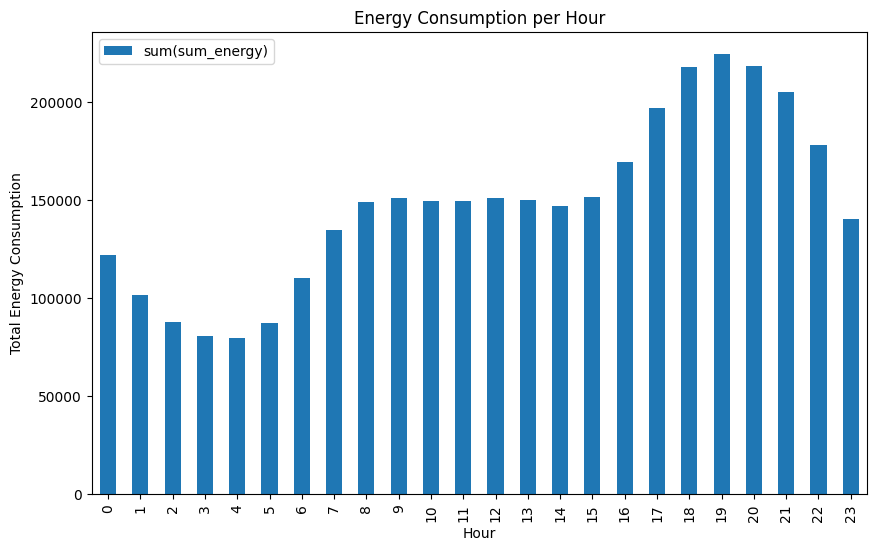

In [ ]:
# Calculate daily energy consumption
# Convert to Pandas DataFrame and sort by day
daily_energy_df = halfhourly.groupBy('hour').sum('sum_energy').toPandas().sort_values('hour')

# Visualize daily energy consumption
fig, ax = plt.subplots(figsize=(10, 6))
daily_energy_df.plot(x='hour', y='sum(sum_energy)', kind='bar', ax=ax)

# Set plot labels and title
plt.xlabel('Hour')
plt.ylabel('Total Energy Consumption')
plt.title('Energy Consumption per Hour')

# Display the plot
plt.show()

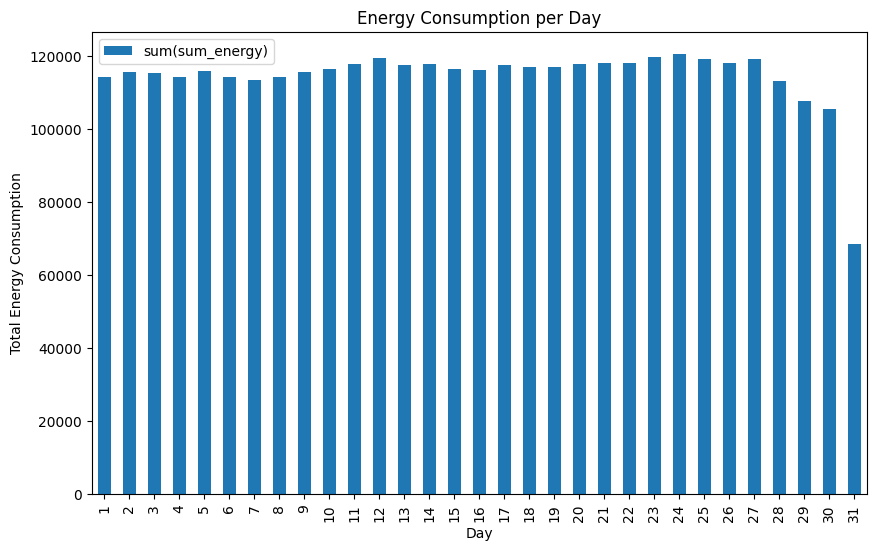

In [ ]:
# Calculate daily energy consumption
# Convert to Pandas DataFrame and sort by day
# Visualize daily energy consumption
fig, ax = plt.subplots(figsize=(10, 6))
halfhourly.groupBy('day').sum('sum_energy').toPandas().sort_values('day').plot(x='day', y='sum(sum_energy)', kind='bar', ax=ax)

# Set plot labels and title
plt.xlabel('Day')
plt.ylabel('Total Energy Consumption')
plt.title('Energy Consumption per Day')

# Display the plot
plt.show()

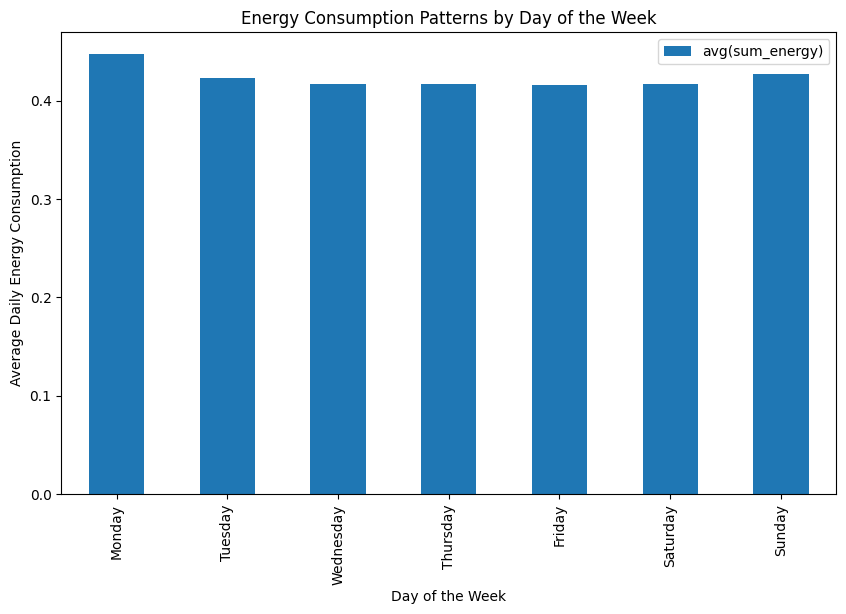

In [ ]:
# Calculate average energy consumption by day of the week
# Convert to Pandas DataFrame
daily_energy_weekday_df = halfhourly.groupBy('dayOfWeek').avg('sum_energy').toPandas()

# Define the order of weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Sort by day of the week
daily_energy_weekday_df['dayOfWeek'] = daily_energy_weekday_df['dayOfWeek'].astype(int)
daily_energy_weekday_df = daily_energy_weekday_df.sort_values('dayOfWeek')
daily_energy_weekday_df['weekday'] = daily_energy_weekday_df['dayOfWeek'].map(lambda x: weekday_order[x-1])

# Visualize energy consumption by day of the week
fig, ax = plt.subplots(figsize=(10, 6))
daily_energy_weekday_df.plot(x='weekday', y='avg(sum_energy)', kind='bar', ax=ax)

# Set plot labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Average Daily Energy Consumption')
plt.title('Energy Consumption Patterns by Day of the Week')

# Display the plot
plt.show()

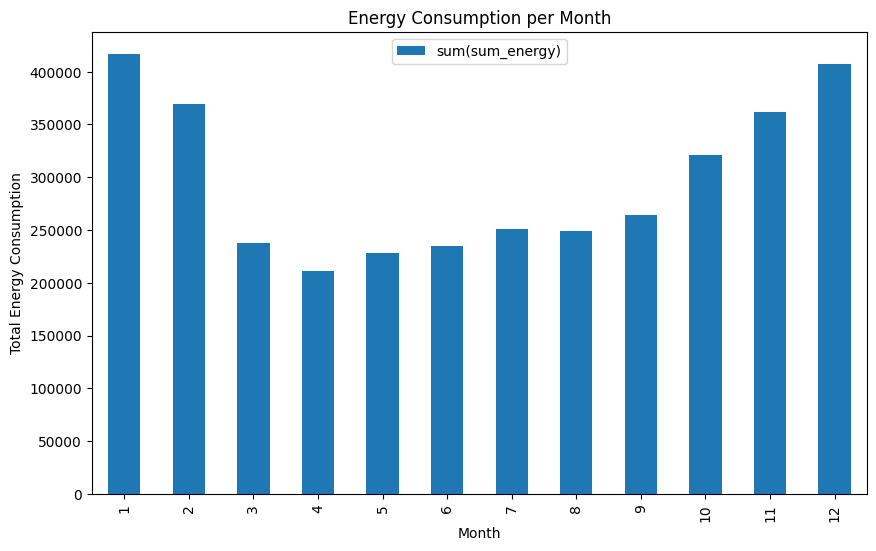

In [ ]:
# Calculate daily energy consumption
# Convert to Pandas DataFrame and sort by day
# Visualize daily energy consumption
fig, ax = plt.subplots(figsize=(10, 6))
halfhourly.groupBy('month').sum('sum_energy').toPandas().sort_values('month').plot(x='month', y='sum(sum_energy)', kind='bar', ax=ax)

# Set plot labels and title
plt.xlabel('Month')
plt.ylabel('Total Energy Consumption')
plt.title('Energy Consumption per Month')

# Display the plot
plt.show()

#Linear Regression on energy consumption and temporal data

In [ ]:
# Create a VectorAssembler to combine the features into a feature vector
assembler = VectorAssembler(
    inputCols=['year', 'month', 'day', 'dayOfWeek', 'hour'],
    outputCol='time_vec'
)

# Create a StandardScaler to normalize the features
scaler = StandardScaler(inputCol='time_vec', outputCol='time_vecS')

train, test = halfhourly.randomSplit([0.8, 0.2], seed=42)

In [ ]:
print("Train Info:\n", train.count())

min_value, max_value = train.agg(min('sum_energy'), max('sum_energy')).first()

print('Minimum sum_energy:', min_value)
print('Maximum sum_energy:', max_value)

Train Info:
 6711226
Minimum sum_energy: 0.0
Maximum sum_energy: 16.76


In [ ]:
print("Test Info:\n", test.count())

min_value, max_value = test.agg(min('sum_energy'), max('sum_energy')).first()

print('Minimum sum_energy:', min_value)
print('Maximum sum_energy:', max_value)

Test Info:
 1678525
Minimum sum_energy: 0.0
Maximum sum_energy: 15.712


In [ ]:
#defining my linear regsion model to use the label col as sum energy and the feature col as time_vecS
lr = LinearRegression(
    labelCol='sum_energy',
    featuresCol='time_vecS',
)


pipeline = Pipeline(stages=[assembler, scaler, lr])

#creating a grid of hyperparameter value for model tuning, this explores different combinarions of regulaization parameters and elastic net mixing parameters for model tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

#performing k-fold crossvalidation on the training data with the specified hyperparameter grid
tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol='sum_energy', metricName='rmse'),
    trainRatio=0.8
)

#Train the model
model = tvs.fit(train)

#Make predictions on the test set
predictions = model.transform(test)

In [ ]:
evaluator_rmse = RegressionEvaluator(labelCol='sum_energy', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='sum_energy', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol='sum_energy', metricName='r2')
evaluator_msle = RegressionEvaluator(labelCol='sum_energy', metricName='mse')

print('Root Mean Squared Error (RMSE):', evaluator_rmse.evaluate(predictions))
print('Mean Absolute Error (MAE):', evaluator_mae.evaluate(predictions))
print('R-squared (R^2):', evaluator_r2.evaluate(predictions))
print('Mean Squared Logarithmic Error (MSLE):', evaluator_msle.evaluate(predictions))

Root Mean Squared Error (RMSE): 0.5498213391966948
Mean Absolute Error (MAE): 0.32674162220398567
R-squared (R^2): 0.0335884922266364
Mean Squared Logarithmic Error (MSLE): 0.3012656458649516


In [ ]:
#defining the base models for model averaging
linear_regression_1 = LinearRegression(
    labelCol='sum_energy',
    featuresCol='time_vecS',
    regParam=0.1,
    elasticNetParam=0.0
)

linear_regression_2 = LinearRegression(
    labelCol='sum_energy',
    featuresCol='time_vecS',
    regParam=0.01,
    elasticNetParam=0.5
)

linear_regression_3 = LinearRegression(
    labelCol='sum_energy',
    featuresCol='time_vecS',
    regParam=0.001,
    elasticNetParam=1.0
)

#create a list of base models
base_models = [linear_regression_1, linear_regression_2, linear_regression_3]

#create an empty list to store the predictions from base models
base_model_predictions = []

#train and make predictions for each base model
for model in base_models:
    pipeline = Pipeline(stages=[assembler, scaler, model])
    base_model = pipeline.fit(train)
    base_model_predictions.append(base_model.transform(test))

#approach: model averaging by averaging the predictions
ensemble_predictions = base_model_predictions[0].select('sum_energy', base_model_predictions[0]['prediction'].alias('prediction_1'))

for i in range(1, len(base_model_predictions)):
    ensemble_predictions = ensemble_predictions.join(
        base_model_predictions[i].select('sum_energy', base_model_predictions[i]['prediction'].alias(f'prediction_{i+1}')),
        on='sum_energy',
        how='inner'
    )

#getting average prediction
prediction_columns = [f'prediction_{i+1}' for i in range(len(base_model_predictions))]
average_expr = reduce(lambda a, b: a + b, (expr(col_name) for col_name in prediction_columns)) / len(base_model_predictions)
ensemble_predictions = ensemble_predictions.withColumn('average_prediction', average_expr)


In [ ]:
evaluator_rmse = RegressionEvaluator(labelCol='sum_energy', predictionCol='average_prediction', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='sum_energy', predictionCol='average_prediction', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol='sum_energy', predictionCol='average_prediction', metricName='r2')
evaluator_msle = RegressionEvaluator(labelCol='sum_energy', predictionCol='average_prediction', metricName='mse')

print('Root Mean Squared Error (RMSE) - Ensemble:', evaluator_rmse.evaluate(ensemble_predictions))
print('Mean Absolute Error (MAE) - Ensemble:', evaluator_mae.evaluate(ensemble_predictions))
print('R-squared (R^2) - Ensemble:', evaluator_r2.evaluate(ensemble_predictions))
print('Mean Squared Logarithmic Error (MSLE) - Ensemble:', evaluator_msle.evaluate(ensemble_predictions))

Root Mean Squared Error (RMSE) - Ensemble: 0.35191603342222166
Mean Absolute Error (MAE) - Ensemble: 0.3331035292844174
R-squared (R^2) - Ensemble: -6.220068832510305
Mean Squared Logarithmic Error (MSLE) - Ensemble: 0.12384489457963008


In [ ]:
for i, model in enumerate(base_models):
    print(f"Base Model {i + 1} Configuration:")
    print("regParam:", model.getRegParam())
    print("elasticNetParam:", model.getElasticNetParam())
    print()

Base Model 1 Configuration:
regParam: 0.1
elasticNetParam: 0.0

Base Model 2 Configuration:
regParam: 0.01
elasticNetParam: 0.5

Base Model 3 Configuration:
regParam: 0.001
elasticNetParam: 1.0



In [ ]:
agg_data_pd = halfhourly.groupBy('Acorn_grouped').count().toPandas()

fig = px.pie(agg_data_pd, names="Acorn_grouped", values="count", title="ACORN Features Distribution")

fig.show()

Joining Bank holidays dataset

In [25]:
halfhourly = halfhourly.join(holidays, halfhourly['time'] == holidays['Bank holidays'], how='left')

In [26]:
halfhourly = halfhourly.drop('Bank holidays')

In [27]:
# 2011-11-23 09:00:00|2014-02-28 00:00:00
start_time = '2011-11-23 09:00:00'
end_time = '2014-02-28 00:00:00'
halfhourly = halfhourly.join(weather, on='time', how='outer') \
                     .where((col('time') >= start_time) & (col('time') <= end_time))

In [ ]:
unique('icon')

fog
partly-cloudy-day
clear-day
cloudy
clear-night
wind
partly-cloudy-night
None


In [ ]:
unique('summary')

Breezy
Windy and Overcast
Foggy
Breezy and Partly Cloudy
Partly Cloudy
Clear
Mostly Cloudy
Breezy and Overcast
Breezy and Mostly Cloudy
Windy and Partly Cloudy
Windy
Windy and Mostly Cloudy
Overcast
None


In [28]:
halfhourly = halfhourly.drop('Summary')

In [ ]:
(halfhourly.select([sum(col(column).isNull().cast("integer")).alias(column) for column in halfhourly.columns])).show()

+----+-----+----------+--------+-----+-------------+----+-----+---+---------+----+-------+----------+-----------+-----------+--------+--------+-------------------+---------+----------+----+--------+
|time|LCLid|sum_energy|stdorToU|Acorn|Acorn_grouped|year|month|day|dayOfWeek|hour|   Type|visibility|windBearing|temperature|dewPoint|pressure|apparentTemperature|windSpeed|precipType|icon|humidity|
+----+-----+----------+--------+-----+-------------+----+-----+---+---------+----+-------+----------+-----------+-----------+--------+--------+-------------------+---------+----------+----+--------+
|   0|   72|        72|      72|   72|           72|  72|   72| 72|       72|  72|2512881|       313|        313|        313|     313|    1954|                313|      313|       313| 313|     313|
+----+-----+----------+--------+-----+-------------+----+-----+---+---------+----+-------+----------+-----------+-----------+--------+--------+-------------------+---------+----------+----+--------+



In [29]:
# Forward fill missing values in the specified columns
for column in ['visibility', 'windBearing', 'temperature', 'dewPoint', 'apparentTemperature',
                   'windSpeed', 'precipType', 'icon', 'humidity']:
    halfhourly = halfhourly.withColumn(column, last(column, ignorenulls=True).over(Window.orderBy("time")))

In [30]:
halfhourly = halfhourly.na.fill({'Type': 'No holiday'})

In [ ]:
halfhourly.filter(col("pressure").isNull()).show()

+-------------------+---------+----------+--------+-------+-------------+----+-----+---+---------+----+----------+----------+-----------+-----------+--------+--------+-------------------+---------+----------+-----------------+--------+
|               time|    LCLid|sum_energy|stdorToU|  Acorn|Acorn_grouped|year|month|day|dayOfWeek|hour|      Type|visibility|windBearing|temperature|dewPoint|pressure|apparentTemperature|windSpeed|precipType|             icon|humidity|
+-------------------+---------+----------+--------+-------+-------------+----+-----+---+---------+----+----------+----------+-----------+-----------+--------+--------+-------------------+---------+----------+-----------------+--------+
|2012-05-07 18:00:00|MAC005032|     0.336|     Std|ACORN-E|     Affluent|2012|    5|  7|        2|  18|No holiday|     11.27|        189|      12.99|    8.29|    NULL|              12.99|     4.22|      rain|partly-cloudy-day|    0.73|
|2012-05-07 18:00:00|MAC002694|     0.327|     ToU|ACORN

In [31]:
halfhourly.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- LCLid: string (nullable = true)
 |-- sum_energy: double (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dayOfWeek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- Type: string (nullable = false)
 |-- visibility: float (nullable = true)
 |-- windBearing: integer (nullable = true)
 |-- temperature: float (nullable = true)
 |-- dewPoint: float (nullable = true)
 |-- pressure: float (nullable = true)
 |-- apparentTemperature: float (nullable = true)
 |-- windSpeed: float (nullable = true)
 |-- precipType: string (nullable = true)
 |-- icon: string (nullable = true)
 |-- humidity: float (nullable = true)



#Correlation between energy consumptiona and weather variables

<ipython-input-47-a1ae037eae17>:6: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



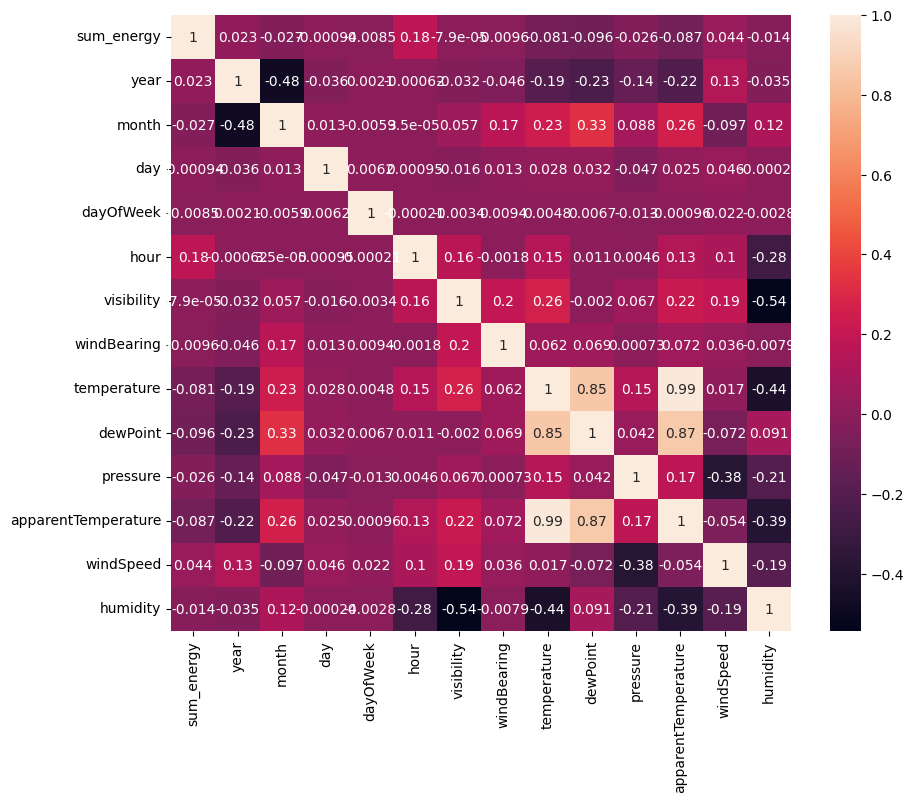

In [ ]:
# Investigation of the relationship between energy consumption and climate variables
# import seaborn as sns
# import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(halfhourly.toPandas().corr(), annot=True)
plt.show()

* Here we are trying to investigate how climate variables may be affected by energy consumption.
* As per the illustration, this is not clearly defined, we cannot really say that energy consumption affects or influences the climate variables as we would have expected.
* The lack of strong correlation here suggests that the relationship between these variables may be more complex or influeced by other factors in addition to energy that are not capttured by the analysis.

as a solution, we may try to review the data, expand the analysis, or explore non-linear relationships

In [32]:
halfhourly = halfhourly.drop('dewPoint', 'apparentTemperature', 'ACORN', 'LCLid')

In [33]:
halfhourly.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- sum_energy: double (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dayOfWeek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- Type: string (nullable = false)
 |-- visibility: float (nullable = true)
 |-- windBearing: integer (nullable = true)
 |-- temperature: float (nullable = true)
 |-- pressure: float (nullable = true)
 |-- windSpeed: float (nullable = true)
 |-- precipType: string (nullable = true)
 |-- icon: string (nullable = true)
 |-- humidity: float (nullable = true)



In [34]:
halfhourly = halfhourly.drop('time')

#Encoding the data And performing Machine Learning model on weather data

In [35]:
halfhourly = halfhourly.dropna()

In [ ]:
halfhourly.count()

2513290

In [39]:
# Assuming `data` is your DataFrame containing the data
categorical_cols = ['stdorToU', 'Acorn_grouped', 'Type', 'precipType', 'icon']
numeric_cols = ['sum_energy', 'visibility', 'windBearing', 'temperature', 'pressure', 'windSpeed', 'humidity']

indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in categorical_cols]

pipeline = Pipeline(stages=indexers)

encoded_data = pipeline.fit(halfhourly).transform(halfhourly)

# Drop the original categorical and numeric columns
encoded_data = encoded_data.drop(*categorical_cols, 'LCLid')

In [40]:
# encoded_data.write.csv('/content/drive/MyDrive/file.csv', header=True, mode="overwrite")

In [24]:
# encoded_data = spark.read.csv('/content/drive/MyDrive/file.csv/part-00000-408078e5-c870-4308-871e-776ce3cbe45b-c000.csv', header=True, inferSchema=True)

In [25]:
encoded_data.printSchema()

root
 |-- sum_energy: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dayOfWeek: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- visibility: double (nullable = true)
 |-- windBearing: integer (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- windSpeed: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- stdorToU_index: double (nullable = true)
 |-- Acorn_grouped_index: double (nullable = true)
 |-- Type_index: double (nullable = true)
 |-- precipType_index: double (nullable = true)
 |-- icon_index: double (nullable = true)



In [27]:
assembler = VectorAssembler(
    inputCols=['year', 'month', 'day', 'dayOfWeek', 'hour', 'visibility',
               'windBearing', 'temperature', 'pressure', 'windSpeed',
               'humidity', 'stdorToU_index', 'Acorn_grouped_index',
               'Type_index', 'precipType_index', 'icon_index'],
    outputCol='weatherT_Data'
)

scaler = StandardScaler(inputCol='weatherT_Data', outputCol='weatherT_Data_vecS')

In [28]:
train, test = encoded_data.randomSplit([0.8, 0.2], seed=42)

In [38]:
# Define the base models for model averaging
linear_regression_1 = LinearRegression(
    labelCol='sum_energy',
    featuresCol='weatherT_Data_vecS',
    regParam=0.1,
    elasticNetParam=0.0
)

linear_regression_2 = LinearRegression(
    labelCol='sum_energy',
    featuresCol='weatherT_Data_vecS',
    regParam=0.01,
    elasticNetParam=0.5
)

linear_regression_3 = LinearRegression(
    labelCol='sum_energy',
    featuresCol='weatherT_Data_vecS',
    regParam=0.001,
    elasticNetParam=1.0
)

# Create a list of base models
base_models = [linear_regression_1, linear_regression_2, linear_regression_3]

# Create an empty list to store the predictions from base models
base_model_predictions = []

# Train and make predictions for each base model
for model in base_models:
    pipeline = Pipeline(stages=[assembler, scaler, model])
    base_model = pipeline.fit(train)
    base_model_predictions.append(base_model.transform(test))

# Perform model averaging by averaging the predictions
ensemble_predictions = base_model_predictions[0].select('sum_energy', base_model_predictions[0]['prediction'].alias('prediction_1'))

for i in range(1, len(base_model_predictions)):
    ensemble_predictions = ensemble_predictions.join(
        base_model_predictions[i].select('sum_energy', base_model_predictions[i]['prediction'].alias(f'prediction_{i+1}')),
        on='sum_energy',
        how='inner'
    )

# Calculate the average prediction
prediction_columns = [f'prediction_{i+1}' for i in range(len(base_model_predictions))]
average_expr = reduce(lambda a, b: a + b, (expr(col_name) for col_name in prediction_columns)) / len(base_model_predictions)
ensemble_predictions = ensemble_predictions.withColumn('average_prediction', average_expr)

In [39]:
evaluator_rmse = RegressionEvaluator(labelCol='sum_energy', predictionCol='average_prediction', metricName='rmse')
evaluator_mae = RegressionEvaluator(labelCol='sum_energy', predictionCol='average_prediction', metricName='mae')
evaluator_r2 = RegressionEvaluator(labelCol='sum_energy', predictionCol='average_prediction', metricName='r2')
evaluator_msle = RegressionEvaluator(labelCol='sum_energy', predictionCol='average_prediction', metricName='mse')

print('Root Mean Squared Error (RMSE) - Ensemble:', evaluator_rmse.evaluate(ensemble_predictions))
print('Mean Absolute Error (MAE) - Ensemble:', evaluator_mae.evaluate(ensemble_predictions))
print('R-squared (R^2) - Ensemble:', evaluator_r2.evaluate(ensemble_predictions))
print('Mean Squared Logarithmic Error (MSLE) - Ensemble:', evaluator_msle.evaluate(ensemble_predictions))

Root Mean Squared Error (RMSE) - Ensemble: 0.29110254819994996
Mean Absolute Error (MAE) - Ensemble: 0.27108147426091705
R-squared (R^2) - Ensemble: -5.077425670024449
Mean Squared Logarithmic Error (MSLE) - Ensemble: 0.08474069356850418


In [36]:
models = [
    RandomForestRegressor(featuresCol='weatherT_Data_vecS', labelCol='sum_energy'),
    DecisionTreeRegressor(featuresCol='weatherT_Data_vecS', labelCol='sum_energy'),
]

eval_metrics = ['rmse', 'mae', 'r2', 'mse']

results = []

for model in models:
    # Build the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, model])

    #train the model
    model_trained = pipeline.fit(train)

    #make predictions
    predictions = model_trained.transform(test)

    #evaluate the model for each metric
    model_name = model.__class__.__name__
    for metric in eval_metrics:
        evaluator = RegressionEvaluator(labelCol='sum_energy', predictionCol='prediction', metricName=metric)
        metric_value = evaluator.evaluate(predictions)
        results.append({'Model': model_name, 'Metric': metric, 'Value': metric_value})

results_df = spark.createDataFrame(results)

In [37]:
results_df.show()

+------+--------------------+--------------------+
|Metric|               Model|               Value|
+------+--------------------+--------------------+
|  rmse|RandomForestRegre...|  0.6142519263708739|
|   mae|RandomForestRegre...|  0.3451079715416037|
|    r2|RandomForestRegre...|0.042718891609291765|
|   mse|RandomForestRegre...| 0.37730542905032943|
|  rmse|DecisionTreeRegre...|  0.6158538254979854|
|   mae|DecisionTreeRegre...| 0.34490455075107046|
|    r2|DecisionTreeRegre...| 0.03771942067322209|
|   mse|DecisionTreeRegre...| 0.37927593438050305|
+------+--------------------+--------------------+



In [ ]:
#fin